## Detecting Spma Email
- อีเมลสแปมคืออีเมล/ข้อความที่ไม่พึงประสงค์หรือไม่ต้องการซึ่งถูกส่งมาเป็นจำนวนมากถึงผู้ใช้ การตรวจจับอีเมลสแปมโดยอัตโนมัติจะช่วยป้องกันความรกที่ไม่จำเป็นในกล่องจดหมายของผู้ใช้

### 1. Import Depndencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
# nltk.download('stopwords')

import tensorflow as tf
from tensorflow import keras
from keras.utils import pad_sequences
from keras.layers import TextVectorization, Embedding, LSTM, Dense
from keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

In [ ]:
TextVectorization??

### 2. Load the Dataset

In [2]:
data = pd.read_csv('spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [6]:
data.shape

(5171, 4)

- 5171 rows, 4 cols

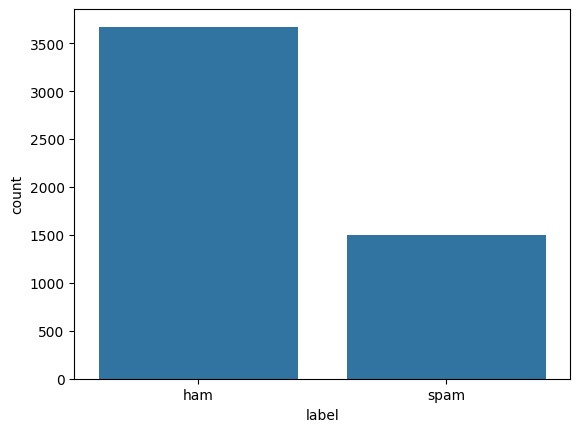

In [3]:
sns.countplot(x='label', data=data)
plt.show()

### 3. Balance the Dataset
- ลดจำนวนตัวอย่างของคลาสส่วนใหญ่ (แฮม) ให้เท่ากับคลาสส่วนน้อย (สแปม)

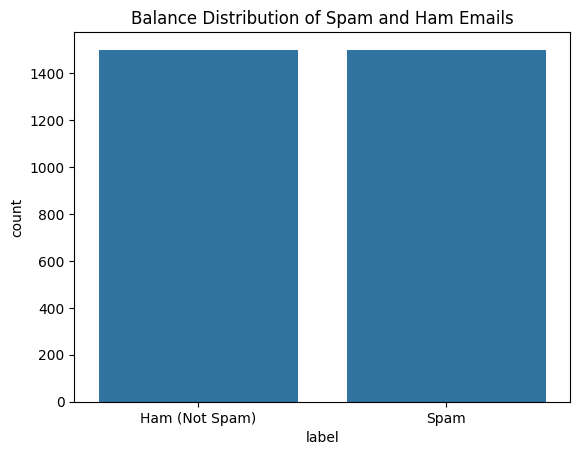

In [4]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

# Downsample Ham emails to math the number of Spam emails
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

# Combine balance data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

# Visualize the balanced Dataset
sns.countplot(x='label', data=balanced_data)
plt.title("Balance Distribution of Spam and Ham Emails")
plt.xticks(ticks=[0, 1], labels=['Ham (Not Spam)', 'Spam'])
plt.show()

### 4. Clean the Text
- ขั้นตอนทั่วไปได้แก่ การลบคำที่ไม่สำคัญ เครื่องหมายวรรคตอน และการหาคำหลัก/คำรากศัพท์

In [5]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [6]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text'] = balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [7]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output

balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


### Visualization Word Clloud

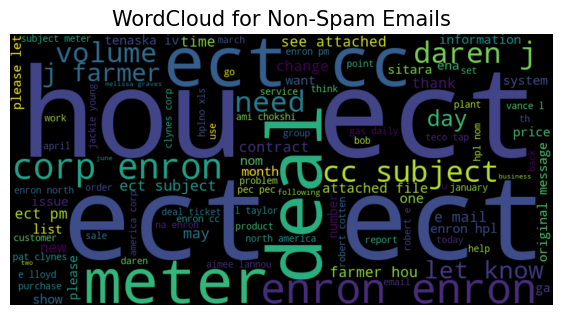

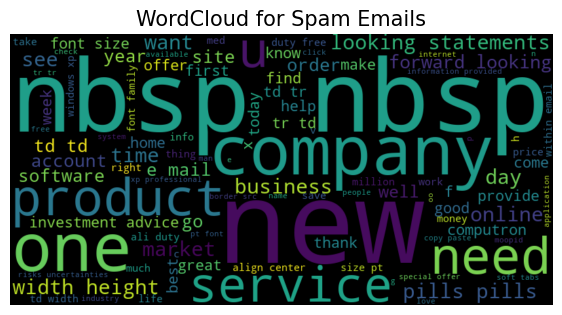

In [8]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')  
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')  

### 6. Tokenization and Padding

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2,
    random_state=42
)

tokenizer = TextVectorization(
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=100
)

test_tokenizer = TextVectorization(
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=100
)

tokenizer.adapt(train_X)
test_tokenizer.adapt(test_X)

max_len = 100
train_sequence = pad_sequences(tokenizer(test_X), maxlen=max_len, padding='post', 
                               truncating='post')
test_sequence = pad_sequences(test_tokenizer(test_X), maxlen=max_len, padding='post', 
                               truncating='post')

train_y = (train_y == 'spam').astype(int)
test_y = (test_y == 'spam').astype(int)

In [46]:
model = Sequential()
model.add(Embedding(len(tokenizer(train_X)), 32, input_length=max_len))
model.add(LSTM(16))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)